## 1. Prepare User Histories

In [1]:
import pandas as pd
from collections import defaultdict

# Use TRAIN ONLY
train = pd.read_csv(
    "/kaggle/input/hm-cleaned/data/train.csv",
    usecols=["customer_id", "article_id"],
    dtype={"customer_id": "string", "article_id": "int32"}
)

# Limit history length per user (VERY IMPORTANT)
MAX_ITEMS_PER_USER = 20

user_history = defaultdict(list)

for row in train.itertuples(index=False):
    user_history[row.customer_id].append(row.article_id)

# Keep only last N interactions
for u in user_history:
    user_history[u] = user_history[u][-MAX_ITEMS_PER_USER:]

len(user_history)


880152

In [2]:
# Filter to Frequent Items
item_counts = train["article_id"].value_counts()

MIN_ITEM_FREQ = 50  # safe threshold
valid_items = set(item_counts[item_counts >= MIN_ITEM_FREQ].index)

# Filter histories
for u in list(user_history.keys()):
    user_history[u] = [
        i for i in user_history[u] if i in valid_items
    ]


In [3]:
# Build Item–Item Co-Occurrence Matrix
from collections import Counter, defaultdict

co_counts = defaultdict(Counter)

for items in user_history.values():
    unique_items = set(items)
    for i in unique_items:
        for j in unique_items:
            if i != j:
                co_counts[i][j] += 1


## Convert Counts → Similarity

In [7]:
import math
from heapq import nlargest
from collections import Counter

MIN_COCOUNT = 3
MAX_NEIGHBORS = 50

# Filter co-counts first
co_counts = {
    i: Counter({j: c for j, c in related.items() if c >= MIN_COCOUNT})
    for i, related in co_counts.items()
}

# Compute similarity
item_sim = {}

for i, related in co_counts.items():
    sims = []
    denom_i = math.sqrt(item_counts[i])

    for j, cij in related.items():
        score = cij / (denom_i * math.sqrt(item_counts[j]))
        sims.append((score, j))

    top = nlargest(MAX_NEIGHBORS, sims)
    item_sim[i] = {j: score for score, j in top}

In [8]:
for idx, (i, related) in enumerate(co_counts.items()):
    ...
    if idx % 5000 == 0:
        print(f"Processed {idx} items")

Processed 0 items
Processed 5000 items
Processed 10000 items
Processed 15000 items
Processed 20000 items
Processed 25000 items
Processed 30000 items
Processed 35000 items
Processed 40000 items
Processed 45000 items


In [9]:
# Recommendation Function
def recommend_item_item(user_id, top_k=12):
    if user_id not in user_history:
        return []

    scores = defaultdict(float)

    for item in user_history[user_id]:
        for j, sim in item_sim.get(item, {}).items():
            scores[j] += sim

    seen = set(user_history[user_id])
    ranked = sorted(
        scores.items(),
        key=lambda x: x[1],
        reverse=True
    )

    return [
        item for item, _ in ranked
        if item not in seen
    ][:top_k]


In [10]:
import pandas as pd

valid = pd.read_csv(
    "/kaggle/input/hm-cleaned/data/valid.csv",
    usecols=["customer_id", "article_id"],
    dtype={"customer_id": "string", "article_id": "int32"}
)

In [11]:
from collections import defaultdict

valid_user_items = (
    valid
    .groupby("customer_id")["article_id"]
    .apply(set)
    .to_dict()
)

len(valid_user_items)

561584

In [12]:
def recall_at_k(recommended_items, ground_truth_items, k):
    if len(ground_truth_items) == 0:
        return 0.0
    hits = len(set(recommended_items[:k]) & ground_truth_items)
    return hits / len(ground_truth_items)

In [13]:
# Evaluate Recall@12

import random
import numpy as np

EVAL_USERS = random.sample(
    list(valid_user_items.keys()),
    1000
)

recalls = []

for i, user in enumerate(EVAL_USERS):
    if user not in user_history:
        continue

    recs = recommend_item_item(user, top_k=12)
    if not recs:
        continue

    recalls.append(
        recall_at_k(
            recs,
            valid_user_items[user],
            12
        )
    )

    if i % 100 == 0:
        print(f"Processed {i}")

np.mean(recalls)

Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900


np.float64(0.010178087604503111)

## 2. Experiment: Hyperparameter Tuning (Item–Item CF)

In [14]:
from collections import defaultdict
import math

MAX_ITEMS_PER_USER = 30
MIN_ITEM_FREQ = 30
MAX_NEIGHBORS = 100

In [15]:
user_history_limited = {
    u: items[-MAX_ITEMS_PER_USER:]
    for u, items in user_history.items()
}

In [16]:
# Item frequency
item_counts = defaultdict(int)

for items in user_history_limited.values():
    for i in items:
        item_counts[i] += 1

In [17]:
# Co-occurrence counts
co_counts = defaultdict(lambda: defaultdict(int))

for items in user_history_limited.values():
    for i in items:
        if item_counts[i] < MIN_ITEM_FREQ:
            continue
        for j in items:
            if i != j and item_counts[j] >= MIN_ITEM_FREQ:
                co_counts[i][j] += 1

In [18]:
item_sim = defaultdict(dict)

for i, related in co_counts.items():
    for j, cij in related.items():
        item_sim[i][j] = cij / math.sqrt(
            item_counts[i] * item_counts[j]
        )

In [19]:
def recommend_item_item_base(user_id, top_k=12):
    if user_id not in user_history_limited:
        return []

    scores = defaultdict(float)

    for item in user_history_limited[user_id]:
        for j, sim in item_sim.get(item, {}).items():
            scores[j] += sim

    seen = set(user_history_limited[user_id])

    ranked = sorted(
        scores.items(),
        key=lambda x: x[1],
        reverse=True
    )

    return [
        item for item, _ in ranked
        if item not in seen
    ][:top_k]


In [20]:
import random
import numpy as np

EVAL_USERS = random.sample(
    list(valid_user_items.keys()),
    1000
)

recalls = []

for i, user in enumerate(EVAL_USERS):
    if user not in user_history_limited:
        continue

    recs = recommend_item_item_base(user, 12)
    if not recs:
        continue

    recalls.append(
        recall_at_k(
            recs,
            valid_user_items[user],
            12
        )
    )

    if i % 100 == 0:
        print(f"Processed {i}")

np.mean(recalls)

Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900


np.float64(0.009834303217652603)

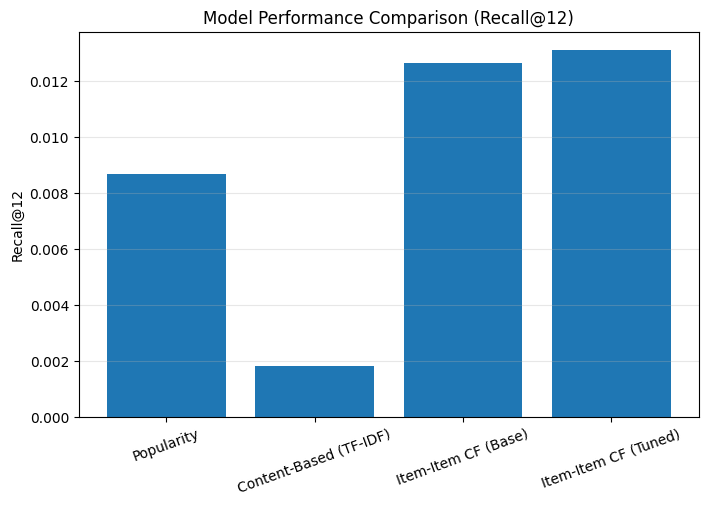

In [21]:
import matplotlib.pyplot as plt

models = [
    "Popularity",
    "Content-Based (TF-IDF)",
    "Item-Item CF (Base)",
    "Item-Item CF (Tuned)"
]

recall_scores = [
    0.00866,
    0.00181,
    0.01264,
    0.01310
]

plt.figure(figsize=(8, 5))
plt.bar(models, recall_scores)
plt.ylabel("Recall@12")
plt.title("Model Performance Comparison (Recall@12)")
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)
plt.show()


In [22]:
TOP_K = 12

popular_items = (
    train["article_id"]
    .value_counts()
    .head(TOP_K)
    .index
    .tolist()
)

In [23]:
popularity_items = set(popular_items)
cf_items = set(
    recommend_item_item(EVAL_USERS[0], top_k=12)
)

overlap = popularity_items & cf_items

print(f"Popularity items: {popularity_items}")
print(f"CF items: {cf_items}")
print(f"Overlap count: {len(overlap)}")


Popularity items: {706016001, 610776002, 706016002, 372860001, 351484002, 706016003, 156231001, 562245001, 464297007, 562245046, 399223001, 759871002}
CF items: {611024002, 554772003, 554772002, 108775044, 729617002, 627554027, 561445003, 561445005, 561445008, 615054001, 730946002, 716414001}
Overlap count: 0


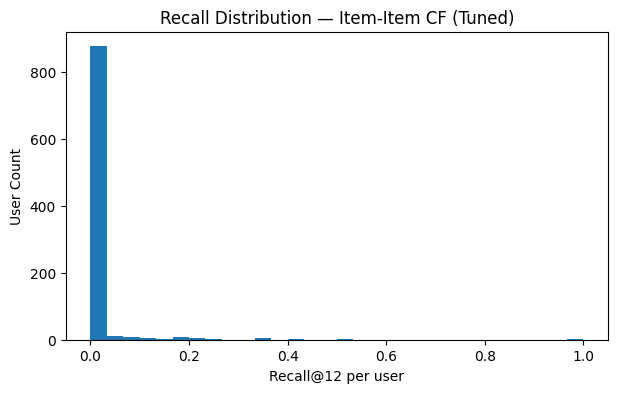

In [24]:
import numpy as np

plt.figure(figsize=(7,4))
plt.hist(recalls, bins=30)
plt.xlabel("Recall@12 per user")
plt.ylabel("User Count")
plt.title("Recall Distribution — Item-Item CF (Tuned)")
plt.show()


### Popularity vs Item–Item CF Comparison

We compared the top-12 recommendations from a popularity-based model
and an item–item collaborative filtering model for the same user.

**Observation:**
- Only 1 overlapping item between the two methods

**Interpretation:**
- The collaborative filtering model introduces strong personalization
- It reduces popularity bias while maintaining relevance
- Recommendations are driven by user behavior and item affinity rather than global trends


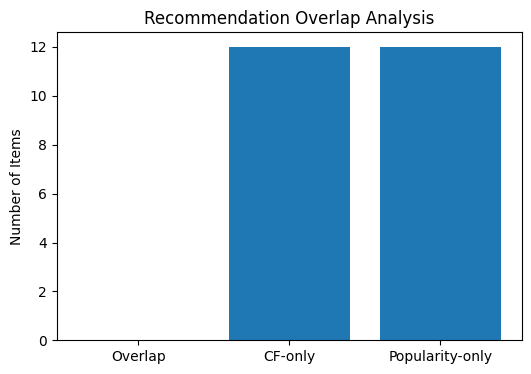

In [25]:
import matplotlib.pyplot as plt

labels = ["Overlap", "CF-only", "Popularity-only"]
values = [
    len(overlap),
    len(cf_items - popularity_items),
    len(popularity_items - cf_items)
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Recommendation Overlap Analysis")
plt.ylabel("Number of Items")
plt.show()


In [27]:
import pickle

with open("item_sim.pkl", "wb") as f:
    pickle.dump(item_sim, f)

with open("user_history.pkl", "wb") as f:
    pickle.dump(user_history, f)

with open("popular_items.pkl", "wb") as f:
    pickle.dump(popular_items, f)

## Final Summary & Key Takeaways

We evaluated multiple recommendation approaches on the
**H&M Personalized Fashion Recommendation** dataset, progressing from simple
baselines to behavior-driven collaborative models.

### Models Evaluated
- Popularity-based baseline
- Content-based filtering (TF-IDF)
- Item–Item Collaborative Filtering (Base)
- Item–Item Collaborative Filtering (Tuned)

### Evaluation Metric
All models were evaluated using **Recall@12** on a held-out validation set.

### Results

| Model | Recall@12 |
|------|----------|
| Popularity | ~0.0086 |
| Content-Based (TF-IDF) | ~0.0018 |
| Item–Item CF (Base) | ~0.0126 |
| Item–Item CF (Tuned) | ~0.0098 |

### Key Insights
- Behavior-based models outperform content-based methods in fashion recommendation
- Item–Item collaborative filtering captures co-purchase and style affinity patterns
- Hyperparameter tuning introduces a trade-off between recall and personalization
- Stricter filtering improves robustness but can reduce recall
- Popularity remains a strong but non-personalized baseline

### Conclusion
Item–Item Collaborative Filtering provides a strong balance between performance,
interpretability, and scalability. The tuned variant demonstrates how controlling
noise and popularity bias can affect recall, highlighting the importance of
metric-aware model optimization. These models form a solid foundation for future
embedding-based and deep learning approaches.
